# Project goals
here, the goal is to create a program than can solve the sythetic inverse problem of a cloth. We will run the forward simulation of the cloth and capture ground truth data in warp, and then try to solve the inverse problem by running an optimization loop in order to tune parameters.

#### Main references used included:
Cloth:
- https://steven.codes/blog/cloth-simulation/
- https://pikuma.com/blog/verlet-integration-2d-cloth-physics-simulation
- https://www.youtube.com/watch?v=qEp70jK8Az0
- https://owlree.blog/posts/simulating-a-rope.html

Warp:
- https://peterchencyc.com/assets/pdf/3664475.3664543.pdf
- https://github.com/NVIDIA/warp
- https://nvidia.github.io/warp/

## 1. forward simulation:

In [6]:
import warp as wp
wp.init()
print("devices: ", wp.get_devices())

devices:  ['cpu']


In [7]:
import warp as wp, math, numpy as np

### 1.1 setting up simulation and cloth

Simulation parameters. 

DT is the discrete time between simulation updates (in the physics world (used for accumulation with the euler method), not how long it takes to do the computation) at 240Hz or 1/240 ms or 4.17 ms. so step 1 happens at 0ms, then step 2 at 4ms, ...

STEPS is how many of the steps should be computed overall in the simulation, computed every DT seconds, which also determines the simulation run time. i.e. how many snapshots are you making.

Need to make a tradeoff between these 2. Higher DT gives more accurate physics, but then I have to double my steps to get the same simulation time which makes a quadratic connection.

In [8]:
#cloth data
W, H = 20, 20 #grid size; makes 400 particles to work with
SPACE_DELTA = 0.05 #space between particles -> defines distance between particles and affects the detail
MASS = 0.02 #per particle in kg

# spring system
K = 200.0 #spring constant; higher = siffer and less strechy cloth
C = 0.01 #damping coefficient. higher values make it less bouncy

#sim control
DT = 1.0 / 240.0
STEPS = 1200

# env
G = 9.81

#config
USE_DIAGONALS = False #use diagonal springs on top of connecting like a grid (so 8 neighbors instead of 4)
DEVICE = wp.get_device()


We will start here by setting up our arrays and data, just as described in the sketch included above. These need to be in numpy first and then transferred to warp. This is because when dealing with warp data types, you would do it inside the kernel itself and we cant efficienty do slicing, indexing or arithmetic with it. They are specifically designed to live on the device and do parallel operations

In [9]:
def make_grid_positions(w, h, dx):
    x = np.zeros(((w*h), 2), dtype=np.float32)
    for j in range(h):
        for i in range(w):
            #note that we are centering from bottom-left here
            idx = j*w+i
            x[idx, 0] = i*dx
            x[idx, 1] = j*dx

    return x

In [10]:
edges = []
for j in range(H):
    for i in range(W):
        if i+1 < W: edges.append((j*W+i, j*W+(i+1)))
        if j+1 < H: edges.append((j*W+i, (j+1)*W+i))
edges = np.array(edges, dtype=np.int32)
edges.shape

(760, 2)

In [11]:
pos = make_grid_positions(W, H, SPACE_DELTA)
pos[0]

array([0., 0.], dtype=float32)

In [12]:
pos[1]

array([0.05, 0.  ], dtype=float32)

In [13]:
pos[1] - pos[0]

array([0.05, 0.  ], dtype=float32)

In [14]:
#TODO: currently diagonals is not being used anywhere
def make_edges_and_rests(w, h, dx, diagonals=USE_DIAGONALS):
    edges = []
    for j in range(h):
        for i in range(w):
            if i+1 < w: edges.append((j*w+i, j*w+(i+1)))
            if j+1 < h: edges.append((j*w+i, (j+1)*w+i))

    #create an array of all the edges, by storing each element as [node1, node2], where the node itself is stored as j*w+i
    edges = np.array(edges, dtype=np.int32)
    rest = np.zeros((edges.shape[0],), dtype=np.float32)
    pos = make_grid_positions(w, h, dx)

    for e, (a,b) in enumerate(edges):
        dir_vec = pos[b] - pos[a]
        rest[e] = np.linalg.norm(dir_vec)

    return edges, rest

In [15]:
edges, rests = make_edges_and_rests(W, H, SPACE_DELTA, False)
rests.shape

(760,)

In [17]:
#if the particle is pinned, mark as 1, otherwise mark it as 0
def make_pins(w, h):
    pins = np.zeros((w*h,), dtype=np.int32)
    pins[(h-1)*w] = 1      # top-left corner                                                                                                                                                                                                       
    pins[(h-1)*w + w-1] = 1  # top-right corner
    return pins

### 1.2 warp kernels and calculations
Now that the functions for setting up the simulation and the cloth are setup, it is time make the simulations in warp

here, the warp kernel runs a bunch of times in parallel, but with different thread ids. in these functions, we are having each thread work on a 

In [18]:
@wp.kernel
def zero_vec2(a: wp.array(dtype=wp.vec2)):
    i = wp.tid()
    a[i] = wp.vec2(0.0, 0.0)

In [19]:
@wp.kernel
def spring_forces(pos: wp.array(dtype=wp.vec2),
                  edges: wp.array2d(dtype=wp.int32),
                  rest: wp.array(dtype=wp.float32),
                  k: float,
                  f: wp.array(dtype=wp.vec2)):
    #what edge and thread we are working with right now
    e = wp.tid()

    #get the indices of connected nodes that we are currently dealing with
    i = edges[e][0]
    j = edges[e][1]

    dir_vec = pos[i] - pos[j] #2d vector
    L = wp.length(dir_vec) + 1e-6 #to prevent div by 0
    dir_unit = dir_vec / L
    Fs = -k * (L - rest[e]) * dir_unit #k*delta_L as a scaled 2d vector
    wp.atomic_add(f, i, Fs)
    wp.atomic_add(f, j, -Fs) #netwons third law; the spring applied Fs to i, and j is connected to its other side so -Fs gets applied

In [20]:
@wp.kernel
def damping_forces(v: wp.array(dtype=wp.vec2),
                   c: float,
                   f: wp.array(dtype=wp.vec2)):
    i = wp.tid()
    wp.atomic_add(f, i, -c*v[i])

In [21]:
@wp.kernel
def integrate(pos: wp.array(dtype=wp.vec2),
              velocities: wp.array(dtype=wp.vec2),
              forces: wp.array(dtype=wp.vec2),
              masses: wp.array(dtype=wp.float32),
              pinned: wp.array(dtype=wp.int32),
              g: float,
              dt: float):

    i = wp.tid()

    if pinned[i] == 1:
        velocities[i] = wp.vec2(0.0, 0.0)
        return
    
    acceleration = forces[i] / masses[i] + wp.vec2(0.0, -g)

    # Using euler integration
    velocities[i] = velocities[i] + acceleration * dt
    pos[i] = pos[i] + velocities[i] * dt

Running the code, you make your arrays for the position, velocity, edges, and rest lengths

a quick implementation note is the difference between how velocity and forces are being instantiated, despite being structured the same (size: particlecount, 2d each holding x and y vector information). we make velocity with numpy, and then turn it into a wp array. this gives flexibility to also start with initial velocities if we want before making it a wp array. f is always zero, so we make it on the device instead if copying from host to avoid unneccessary overhead.

In [22]:
def setup_data():
    pos_np = make_grid_positions(W, H, SPACE_DELTA).astype(np.float32)
    velcoity_np = np.zeros_like(pos_np)
    edges_np, rest_np = make_edges_and_rests(W, H, SPACE_DELTA, USE_DIAGONALS)
    pins_np = make_pins(W, H)
    masses_np = np.full(W*H, MASS)

    pos = wp.array(pos_np, dtype=wp.vec2, device=DEVICE)
    velocity = wp.array(velcoity_np, dtype=wp.vec2, device=DEVICE)
    edges = wp.array(edges_np, dtype=wp.int32, device=DEVICE)
    rest = wp.array(rest_np, dtype=wp.float32, device=DEVICE)
    pins = wp.array(pins_np, dtype=wp.int32, device=DEVICE)
    masses = wp.array(masses_np, dtype=float, device=DEVICE)
    forces = wp.zeros(W*H, dtype=wp.vec2, device=DEVICE)

    return pos, velocity, edges, rest, pins, masses, forces

In [23]:
def run_sim(frames):
    pos, velocity, edges, rest, pins, masses, forces = setup_data()
    pos_np = pos.numpy()

    for t in range(STEPS):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
        wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(K), forces], device=DEVICE)
        wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(C), forces], device=DEVICE)
        wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(G), float(DT)], device=DEVICE)

        frames.append(pos_np.copy()) #important: the copy is neccessary, because without it the same pos is appended everytime. later, when trying to get the stack of frames, I get a bunch of the same positionss not actual trajectories
    
    return np.array(frames)

In [24]:
def run_sim_local(frames, k_debug, c_debug, dt_debug, g_debug):
    pos, velocity, edges, rest, pins, masses, forces = setup_data()
    pos_np = pos.numpy()

    for t in range(STEPS):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
        wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(k_debug), forces], device=DEVICE)
        wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(c_debug), forces], device=DEVICE)
        wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(g_debug), float(dt_debug)], device=DEVICE)

        pos_np = pos.numpy()
        frames.append(pos_np.copy())

    return np.array(frames)

In [25]:
def save_sim(sim_frames):
    traj = np.stack(sim_frames)  # (frames, particle count, 2)
    np.save("cloth_target.npy", traj)
    print("Saved ground-truth to cloth_target.npy with shape", traj.shape)

## 1.3 Tests and debugging

might be a good idea to plot the position a pin with x vs. t and y vs. t

In [26]:
pos, velocity, edges, rest, pins, masses, forces = setup_data()
print(f"{np.array(pos)}")

[[0.   0.  ]
 [0.05 0.  ]
 [0.1  0.  ]
 [0.15 0.  ]
 [0.2  0.  ]
 [0.25 0.  ]
 [0.3  0.  ]
 [0.35 0.  ]
 [0.4  0.  ]
 [0.45 0.  ]
 [0.5  0.  ]
 [0.55 0.  ]
 [0.6  0.  ]
 [0.65 0.  ]
 [0.7  0.  ]
 [0.75 0.  ]
 [0.8  0.  ]
 [0.85 0.  ]
 [0.9  0.  ]
 [0.95 0.  ]
 [0.   0.05]
 [0.05 0.05]
 [0.1  0.05]
 [0.15 0.05]
 [0.2  0.05]
 [0.25 0.05]
 [0.3  0.05]
 [0.35 0.05]
 [0.4  0.05]
 [0.45 0.05]
 [0.5  0.05]
 [0.55 0.05]
 [0.6  0.05]
 [0.65 0.05]
 [0.7  0.05]
 [0.75 0.05]
 [0.8  0.05]
 [0.85 0.05]
 [0.9  0.05]
 [0.95 0.05]
 [0.   0.1 ]
 [0.05 0.1 ]
 [0.1  0.1 ]
 [0.15 0.1 ]
 [0.2  0.1 ]
 [0.25 0.1 ]
 [0.3  0.1 ]
 [0.35 0.1 ]
 [0.4  0.1 ]
 [0.45 0.1 ]
 [0.5  0.1 ]
 [0.55 0.1 ]
 [0.6  0.1 ]
 [0.65 0.1 ]
 [0.7  0.1 ]
 [0.75 0.1 ]
 [0.8  0.1 ]
 [0.85 0.1 ]
 [0.9  0.1 ]
 [0.95 0.1 ]
 [0.   0.15]
 [0.05 0.15]
 [0.1  0.15]
 [0.15 0.15]
 [0.2  0.15]
 [0.25 0.15]
 [0.3  0.15]
 [0.35 0.15]
 [0.4  0.15]
 [0.45 0.15]
 [0.5  0.15]
 [0.55 0.15]
 [0.6  0.15]
 [0.65 0.15]
 [0.7  0.15]
 [0.75 0.15]
 [0.8  0.15]

Note: warp's .numpy() function only copies the data if the array is stored in the gpu. if it is already in cpu, only a reference gets passed. just wanted to make a note to avoid issues like this in future. this is also why i added the .copy() function

### Debugging - dont run this code
Error was fixed later. I basically was appending pos to frames without making a copy, essentially ending up with a bunch of references and at the end having a bunch of elements that represent tha last frame. Decided to keep this here for reference for later

In [ ]:

pos, velocity, edges, rest, pins, masses, forces = setup_data()
print(f"{np.array(pos)[5][0]}")

positions_plot = []

for t in range(STEPS):
    wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
    wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(K), forces], device=DEVICE)
    wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(C), forces], device=DEVICE)
    wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(G), float(DT)], device=DEVICE)

    pos_np = pos.numpy()
    positions_plot.append(pos_np.copy()) #had to do .copy() in case device is cpu, otherwise a reference would be passed each time
    #print(f"{np.array(pos_np)[5][0]}")

    print(f"Timestep {t}: pos_np[5] = {pos_np[5]}")
    
    # Check if the appended data is correct
    if t < 20:  # Just check first few timesteps
        print(f"  positions_plot[{t}][5] = {positions_plot[t][5]}")


In [ ]:
# First, let's verify what we have in positions_plot right after the simulation
print("=== DEBUGGING positions_plot ===")
print("Type of positions_plot:", type(positions_plot))
print("Length of positions_plot:", len(positions_plot))
print("Type of first element:", type(positions_plot[0]))
print("Shape of first element:", positions_plot[0].shape)

# Check a few specific timesteps that we know should be different
print("\n=== CHECKING SPECIFIC TIMESTEPS ===")
print("Timestep 0, particle 5:", positions_plot[0][5])
print("Timestep 10, particle 5:", positions_plot[10][5])
print("Timestep 100, particle 5:", positions_plot[100][5])
print("Timestep 500, particle 5:", positions_plot[500][5])
print("Timestep 1199, particle 5:", positions_plot[1199][5])

# Now let's check what happens when we enumerate
print("\n=== CHECKING ENUMERATION ===")
for t, positions_at_t in enumerate(positions_plot):
    if t in [0, 10, 100, 500, 1199]:  # Only check specific timesteps
        print(f"Timestep {t}, particle 5: {positions_at_t[5]}")
    if t > 1200:  # Safety check
        break

In [ ]:
def debug_sim(k_debug, c_debug, dt_debug, g_debug):
    pos, velocity, edges, rest, pins, masses, forces = setup_data()
    #print(f"{np.array(pos)[5][0]}")

    positions_plot = []

    for t in range(STEPS):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces], device=DEVICE)
        wp.launch(spring_forces, dim=edges.shape[0], inputs=[pos, edges, rest, float(k_debug), forces], device=DEVICE)
        wp.launch(damping_forces, dim=W*H, inputs=[velocity, float(c_debug), forces], device=DEVICE)
        wp.launch(integrate, dim=W*H, inputs=[pos, velocity, forces, masses, pins, float(g_debug), float(dt_debug)], device=DEVICE)

        pos_np = pos.numpy()
        positions_plot.append(pos_np.copy()) #had to do .copy() in case device is cpu, otherwise a reference would be passed each time
        #print(f"{np.array(pos_np)[5][0]}")

    return np.array(positions_plot)

In [ ]:
pos_test = debug_sim(K, C, DT, G)
# First, let's verify what we have in positions_plot right after the simulation
print("=== DEBUGGING positions_plot ===")
print("Type of positions_plot:", type(positions_plot))
print("Length of positions_plot:", len(positions_plot))
print("Type of first element:", type(positions_plot[0]))
print("Shape of first element:", positions_plot[0].shape)

# Check a few specific timesteps that we know should be different
print("\n=== CHECKING SPECIFIC TIMESTEPS ===")
print("Timestep 0, particle 5:", positions_plot[0][5])
print("Timestep 10, particle 5:", positions_plot[10][5])
print("Timestep 100, particle 5:", positions_plot[100][5])
print("Timestep 500, particle 5:", positions_plot[500][5])
print("Timestep 1199, particle 5:", positions_plot[1199][5])

# Now let's check what happens when we enumerate
print("\n=== CHECKING ENUMERATION ===")
for t, positions_at_t in enumerate(positions_plot):
    if t in [0, 10, 100, 500, 1199]:  # Only check specific timesteps
        print(f"Timestep {t}, particle 5: {positions_at_t[5]}")
    if t > 1200:  # Safety check
        break

### Testing stars here

In [27]:
import matplotlib.pyplot as plt

In [28]:
positions_plot = []
positions_plot_np =run_sim(positions_plot)

Module __main__ 0f702b6 load on device 'cpu' took 17.06 ms  (cached)


Plotting an arbitrary particle against time

In [30]:
def plot_at_index_vs_time(index, pos_plot_np):
    timesteps = np.arange(STEPS)
    x_vals = pos_plot_np[:, index, 0]
    y_vals = pos_plot_np[:, index, 1]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, x_vals)
    plt.title(f'Particle {index} X vs. t')
    plt.xlabel('Timestep')
    plt.ylabel('X Position')

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, y_vals)
    plt.title(f'Particle {index} Y vs. t')
    plt.xlabel('Timestep')
    plt.ylabel('Y Position')

    plt.tight_layout()
    plt.show()

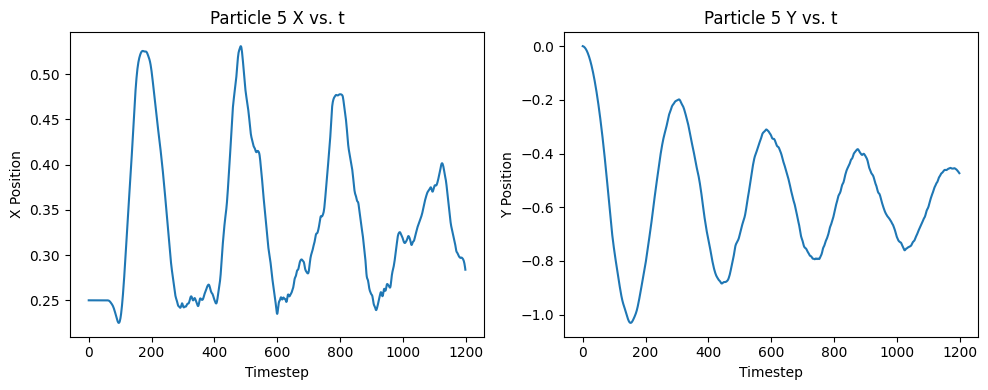

In [31]:
plot_at_index_vs_time(5, positions_plot_np)

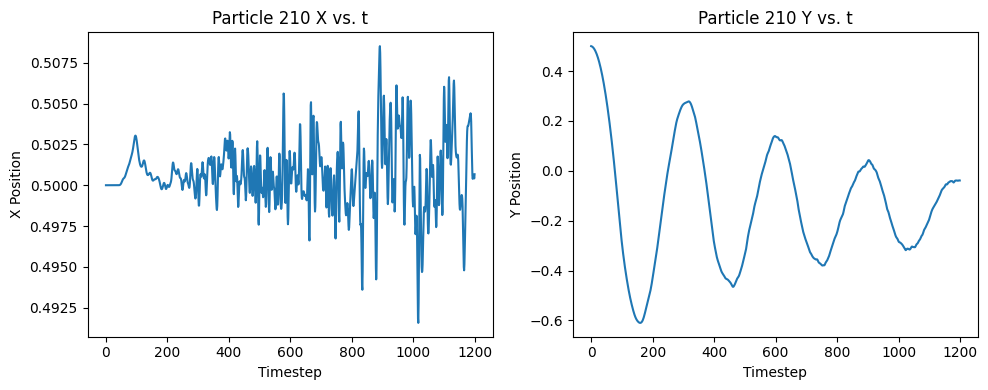

In [32]:
plot_at_index_vs_time(210, positions_plot_np)

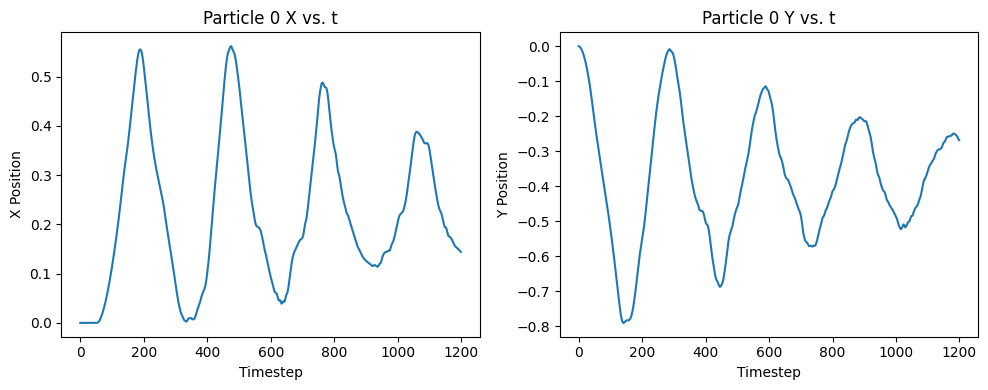

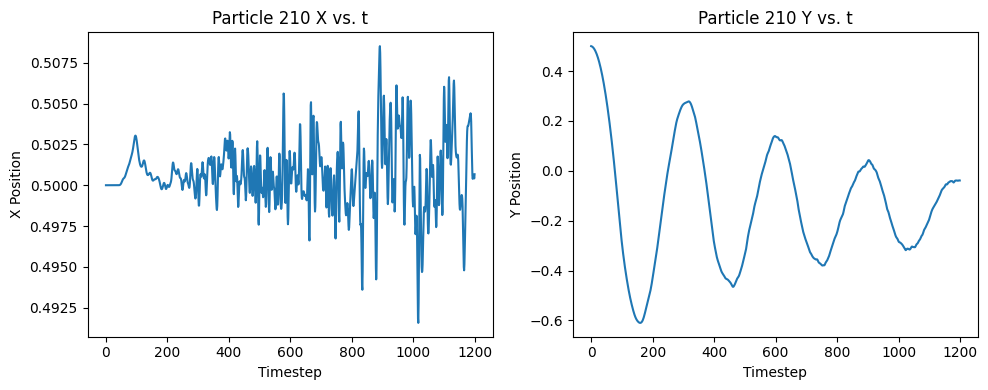

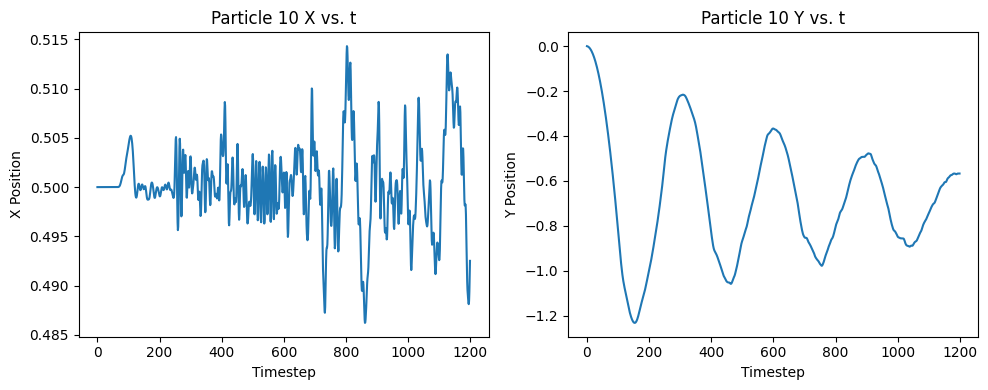

In [33]:
#keep in mind x is horizontal left to right direction, and 
plot_at_index_vs_time(0, positions_plot_np)
plot_at_index_vs_time(210, positions_plot_np)
plot_at_index_vs_time(10, positions_plot_np)

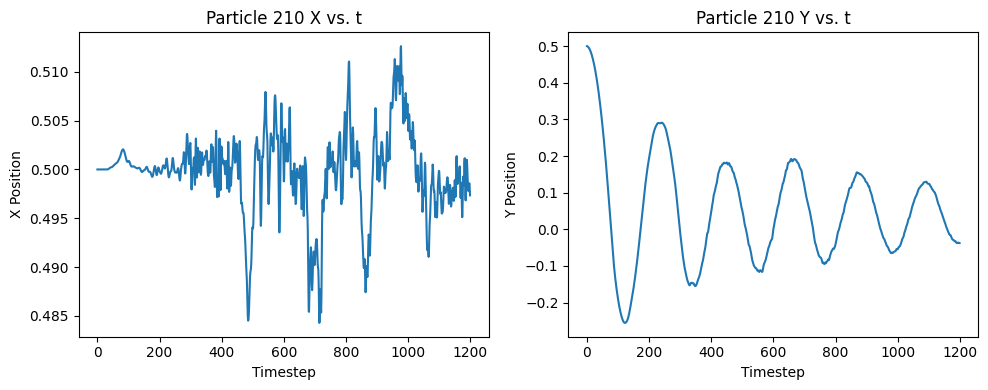

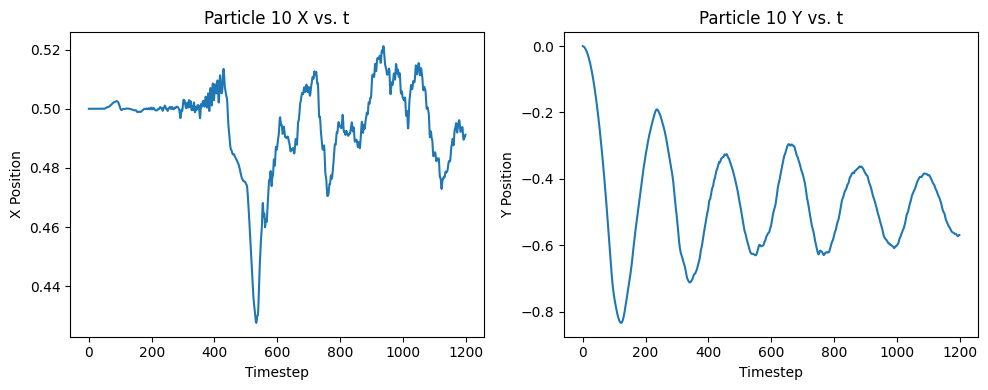

In [34]:
# changing k and c
pos_1_np = run_sim_local([], 400.0, 0.01, 1.0/240.0, 9.81)
plot_at_index_vs_time(210, pos_1_np)
plot_at_index_vs_time(10, pos_1_np)

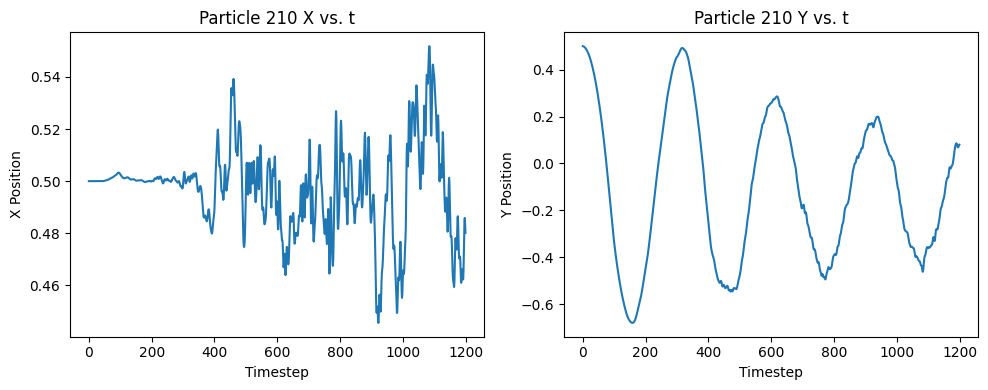

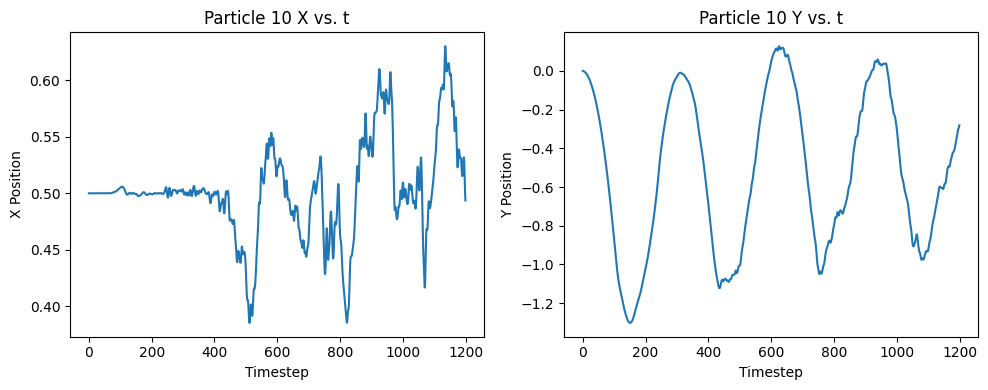

In [35]:
# no damping
pos_2 = run_sim_local([], 200.0, 0.0, 1.0/240.0, 9.81)
plot_at_index_vs_time(210, pos_2)
plot_at_index_vs_time(10, pos_2)

These jitters are caused by how we are doing out integration, which can introduce jitters and also cause the energy to explore (how for particle 10 the amplitude increases here at later timesteps). Lets see if changing dt will fix this

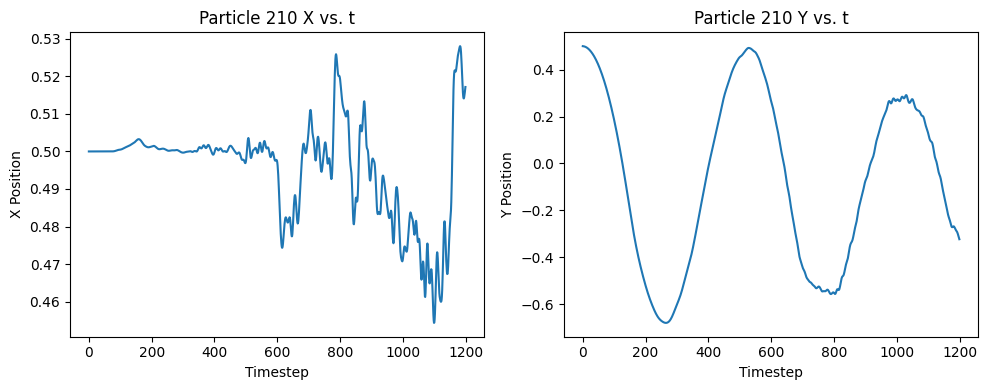

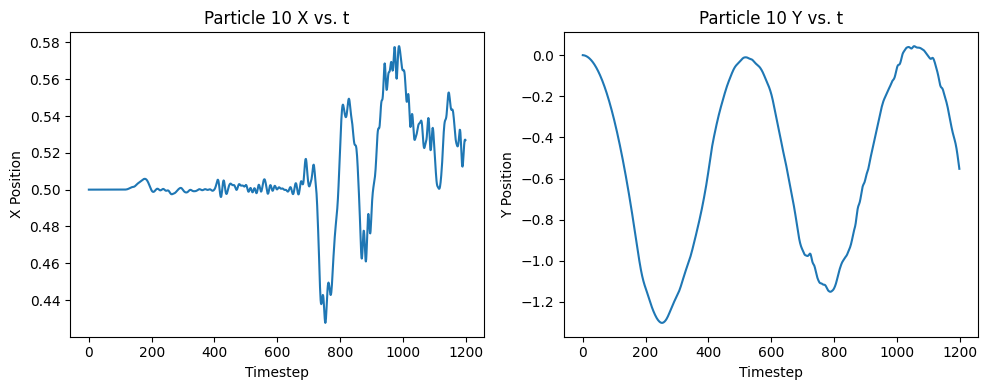

In [36]:
# reduce dt
pos_3 = run_sim_local([], 200.0, 0.0, 1.0/400.0, 9.81)
plot_at_index_vs_time(210, pos_3)
plot_at_index_vs_time(10, pos_3)

generally, for stiffer springs, especially considering the ratio of stiffness to damping, we need higher dt. k/c ratio is also important. we can also try verlet integration

now moving on to visualizing the whole thing

In [37]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_particles(trajectory, save_gif=True):
    """Create an animated scatter plot of particle positions"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def animate(frame):
        ax.clear()
        positions = trajectory[frame]
        ax.scatter(positions[:, 0], positions[:, 1], s=20, alpha=0.7)
        ax.set_xlim(trajectory[:, :, 0].min() - 0.1, trajectory[:, :, 0].max() + 0.1)
        ax.set_ylim(trajectory[:, :, 1].min() - 0.1, trajectory[:, :, 1].max() + 0.1)
        ax.set_title(f'Cloth Simulation - Frame {frame}/{len(trajectory)}')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.grid(True, alpha=0.3)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(trajectory), 
                                 interval=50, repeat=True)
    
    if save_gif:
        anim.save('cloth_animation.gif', writer='pillow')
    
    #plt.show()
    return anim

In [39]:
trajectory = run_sim_local([], 200.0, 0.005, 1.0/400.0, 9.81)

this successfully gives us a gif that simulates how the cloth is moving!! now we can confirm that the code is indeed working properly and can move on to the next stage

In [40]:
def plot_3d_trajectories(trajectory, particle_indices=None):
    """Plot 3D trajectories of selected particles (x, y, time)"""
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    if particle_indices is None:
        particle_indices = [0, 50, 100, 150, 200, 250, 300, 350]  # Sample particles
    
    time_steps = np.arange(len(trajectory))
    
    for idx in particle_indices:
        x = trajectory[:, idx, 0]
        y = trajectory[:, idx, 1]
        ax.plot(x, y, time_steps, label=f'Particle {idx}', linewidth=2)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Time Step')
    ax.set_title('3D Particle Trajectories')
    ax.legend()
    plt.show()

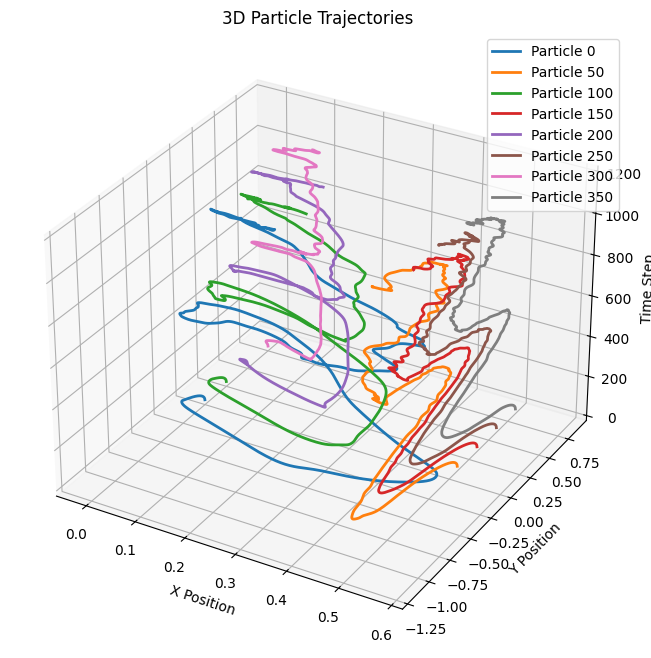

In [41]:
plot_3d_trajectories(trajectory)

## 2 determining parameters with warp

now that we know the original simulation works properly, we can move onto creating our ground truth data. This is generated synthetically here, but in more real world applications it could be from videos, motion-capture, or rendered detections

In [42]:
K = 100
C = 0.2

frames_np = run_sim([])
save_sim(frames_np)

Saved ground-truth to cloth_target.npy with shape (1200, 400, 2)


In [43]:
#load the saved data
gt_np = np.load("cloth_target.npy")

#turn the data to warpvector
trajectory_wp = wp.array(gt_np.astype(np.float32), dtype=wp.vec2, device=DEVICE)

we start with an initial guess for the k and c parameters. saving them as logc and logk makes sure that the value is always positive once we want to get the actual k and c again since we would have to so e^logc and e^logk.

In [44]:
#take these as parameter inputs in the terminal later
kguess = 200.0
cguess = 1e-3

log_k = wp.array(np.array([np.log(kguess)], np.float32), requires_grad=True, device=DEVICE)
log_c = wp.array(np.array([np.log(cguess)], np.float32), requires_grad=True, device=DEVICE)

def current_params():
    # returns Python floats (avoid device scalars in prints)
    return float(wp.exp(log_k)[0]), float(wp.exp(log_c)[0])

We also need to setup buffers

In [45]:
pos_rev, velocity_rev, edges_rev, rest_rev, pins_rev, masses_rev, forces_rev = setup_data()  # your function

Theres also a mask that we need. this is to not include the pinned particles, as can make the gradient useless 

In [46]:
free_mask = (1 - np.array(pins_rev).astype(np.int32)).astype(np.float32)
mask_d = wp.array(free_mask, dtype=wp.float32, device=DEVICE)

In [47]:
@wp.kernel
def mse_frame(x_sim: wp.array(dtype=wp.vec2),
               x_gt:  wp.array(dtype=wp.vec2),
               mask:  wp.array(dtype=wp.float32),
               out:   wp.array(dtype=wp.float32)):
    i = wp.tid()
    d = x_sim[i] - x_gt[i]
    out[i] = mask[i] * wp.dot(d, d)

In [48]:
def reset_to_initial(pos: wp.array(dtype=wp.vec2), vel: wp.array(dtype=wp.vec2)):
    wp.copy(pos, trajectory_wp[0])             # match ground-truth pose at t=0
    wp.launch(zero_vec2, dim=W*H, inputs=[vel], device=DEVICE)  # start from rest

In [49]:
@wp.kernel
def exp_kernel(input_array: wp.array(dtype=wp.float32), output_array: wp.array(dtype=wp.float32)):
    i = wp.tid()
    output_array[i] = wp.exp(input_array[i])

In [50]:
@wp.kernel
def accumulate_loss(tmp: wp.array(dtype=float),
                    mask: wp.array(dtype=float),
                    total: wp.array(dtype=float)):
    """Accumulate MSE into total, normalized by number of free particles."""
    # This runs with dim=1 (single thread)
    sum_err = float(0.0)
    sum_mask = float(0.0)
    for i in range(tmp.shape[0]):
        sum_err = sum_err + tmp[i]
        sum_mask = sum_mask + mask[i]
    total[0] = total[0] + sum_err / (sum_mask + 1e-8)


In [51]:
@wp.kernel
def spring_forces_diff(pos: wp.array(dtype=wp.vec2),
                       edges: wp.array2d(dtype=wp.int32),
                       rest: wp.array(dtype=wp.float32),
                       log_k: wp.array(dtype=wp.float32),
                       f: wp.array(dtype=wp.vec2)):
    e = wp.tid()
    
    k = wp.exp(log_k[0])
    
    i = edges[e][0]
    j = edges[e][1]

    dir_vec = pos[i] - pos[j]
    L = wp.length(dir_vec) + 1e-6
    dir_unit = dir_vec / L
    Fs = -k * (L - rest[e]) * dir_unit
    wp.atomic_add(f, i, Fs)
    wp.atomic_add(f, j, -Fs)

In [52]:
@wp.kernel
def damping_forces_diff(v: wp.array(dtype=wp.vec2),
                        log_c: wp.array(dtype=wp.float32),
                        f: wp.array(dtype=wp.vec2)):
    i = wp.tid()
    c = wp.exp(log_c[0])
    wp.atomic_add(f, i, -c * v[i])

In [53]:
def rollout_and_loss(log_k, log_c, frame_stride=8, reg=1e-4):
    #k = float(np.exp(log_k.numpy()[0]))
    #c = float(np.exp(log_c.numpy()[0]))

    reset_to_initial(pos_rev, velocity_rev)

    total = wp.zeros(1, dtype=float, requires_grad=True, device=DEVICE)

    for t in range(1, STEPS):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces_rev], device=DEVICE)
        wp.launch(spring_forces_diff, dim=edges_rev.shape[0], 
                  inputs=[pos_rev, edges_rev, rest_rev, log_k, forces_rev], device=DEVICE)
        wp.launch(damping_forces_diff, dim=W*H, 
                  inputs=[velocity_rev, log_c, forces_rev], device=DEVICE)
        wp.launch(integrate, dim=W*H, 
                  inputs=[pos_rev, velocity_rev, forces_rev, masses_rev, pins_rev, G, DT], device=DEVICE)

        if (t % frame_stride) == 0 or t == STEPS-1:
            tmp = wp.zeros(W*H, dtype=float, requires_grad=True, device=DEVICE)
            wp.launch(mse_frame, dim=W*H, 
                      inputs=[pos_rev, trajectory_wp[t], mask_d, tmp], device=DEVICE)
            # Use kernel for accumulation instead of Python operations
            wp.launch(accumulate_loss, dim=1, 
                      inputs=[tmp, mask_d, total], device=DEVICE)
    
    return total


In [54]:
@wp.kernel
def update_param(param: wp.array(dtype=float), grad: float, lr: float):
    param[0] = param[0] - lr * grad

In [55]:
# Original full version (will be slow on CPU - expect 10-20+ minutes)
# Only run this after verifying the short version works

def run_full_optimization():
    # Reset parameters
    log_k_full = wp.array(np.array([np.log(200.0)], np.float32), requires_grad=True, device=DEVICE)
    log_c_full = wp.array(np.array([np.log(1e-3)], np.float32), requires_grad=True, device=DEVICE)

    lr = 1e-1
    for it in range(200):
        with wp.Tape() as tape:
            loss = rollout_and_loss(log_k_full, log_c_full, frame_stride=4, reg=1e-4)

        tape.backward(loss)

        gk = float(tape.gradients[log_k_full].numpy()[0])
        gc = float(tape.gradients[log_c_full].numpy()[0])

        # gradient clip
        gnorm = float(np.sqrt((gk**2 + gc**2)))
        if gnorm > 10.0:
            gk *= 10.0/gnorm
            gc *= 10.0/gnorm

        # SGD step
        wp.launch(update_param, dim=1, inputs=[log_k_full, gk, lr])
        wp.launch(update_param, dim=1, inputs=[log_c_full, gc, lr])

        if it % 10 == 0:
            print(f"iter {it:03d} loss={float(loss.numpy()[0]):.6f}  k={float(np.exp(log_k_full.numpy()[0])):.3f}  c={float(np.exp(log_c_full.numpy()[0])):.6e}")

    # learned params
    K_hat = float(np.exp(log_k_full.numpy()[0]))
    C_hat = float(np.exp(log_c_full.numpy()[0]))
    print(f"\nRecovered: K={K_hat:.3f} (target: {K}), C={C_hat:.6f} (target: {C})")
    return K_hat, C_hat

# Uncomment to run:
# K_hat, C_hat = run_full_optimization()

In [ ]:
# First, let's test with a MUCH shorter horizon to verify the code works
# We'll use a subset of the simulation

TEST_STEPS = 100  # Only use first 100 steps for now

def rollout_and_loss_short(log_k, log_c, num_steps=TEST_STEPS, frame_stride=10):
    reset_to_initial(pos_rev, velocity_rev)
    total = wp.zeros(1, dtype=float, requires_grad=True, device=DEVICE)

    for t in range(1, num_steps):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces_rev], device=DEVICE)
        wp.launch(spring_forces_diff, dim=edges_rev.shape[0], 
                  inputs=[pos_rev, edges_rev, rest_rev, log_k, forces_rev], device=DEVICE)
        wp.launch(damping_forces_diff, dim=W*H, 
                  inputs=[velocity_rev, log_c, forces_rev], device=DEVICE)
        wp.launch(integrate, dim=W*H, 
                  inputs=[pos_rev, velocity_rev, forces_rev, masses_rev, pins_rev, G, DT], device=DEVICE)

        if (t % frame_stride) == 0 or t == num_steps - 1:
            tmp = wp.zeros(W*H, dtype=float, requires_grad=True, device=DEVICE)
            wp.launch(mse_frame, dim=W*H, 
                      inputs=[pos_rev, trajectory_wp[t], mask_d, tmp], device=DEVICE)
            wp.launch(accumulate_loss, dim=1, 
                      inputs=[tmp, mask_d, total], device=DEVICE)
    
    return total

# Reset parameters
log_k = wp.array(np.array([np.log(200.0)], np.float32), requires_grad=True, device=DEVICE)
log_c = wp.array(np.array([np.log(1e-3)], np.float32), requires_grad=True, device=DEVICE)

lr = 0.1
print("Starting optimization (short horizon test)...")
print(f"Ground truth: K={K}, C={C}")
print(f"Initial guess: K={np.exp(log_k.numpy()[0]):.1f}, C={np.exp(log_c.numpy()[0]):.1e}")

for it in range(20):  # Just 20 iterations to test
    with wp.Tape() as tape:
        loss = rollout_and_loss_short(log_k, log_c, num_steps=100, frame_stride=10)

    tape.backward(loss)

    # Check if gradients exist
    if log_k not in tape.gradients:
        print(f"ERROR: No gradient for log_k at iteration {it}")
        break
    
    gk = float(tape.gradients[log_k].numpy()[0])
    gc = float(tape.gradients[log_c].numpy()[0])

    # gradient clip
    gnorm = float(np.sqrt((gk**2 + gc**2)))
    if gnorm > 10.0:
        gk *= 10.0/gnorm
        gc *= 10.0/gnorm

    # SGD step
    wp.launch(update_param, dim=1, inputs=[log_k, gk, lr])
    wp.launch(update_param, dim=1, inputs=[log_c, gc, lr])

    if it % 5 == 0:
        k_val = float(np.exp(log_k.numpy()[0]))
        c_val = float(np.exp(log_c.numpy()[0]))
        print(f"iter {it:03d} loss={float(loss.numpy()[0]):.6f}  k={k_val:.3f}  c={c_val:.6e}  |grad|={gnorm:.2e}")

print("\nFinal recovered parameters:")
print(f"K_hat = {float(np.exp(log_k.numpy()[0])):.3f} (target: {K})")
print(f"C_hat = {float(np.exp(log_c.numpy()[0])):.6f} (target: {C})")

In [ ]:
# TINY test first - just 10 steps, 2 iterations to verify gradients work
# If this works in < 30 seconds, we know the code is correct

TEST_STEPS = 10  # Very short horizon

def rollout_and_loss_tiny(log_k, log_c, num_steps=TEST_STEPS):
    reset_to_initial(pos_rev, velocity_rev)
    total = wp.zeros(1, dtype=float, requires_grad=True, device=DEVICE)

    for t in range(1, num_steps):
        wp.launch(zero_vec2, dim=W*H, inputs=[forces_rev], device=DEVICE)
        wp.launch(spring_forces_diff, dim=edges_rev.shape[0], 
                  inputs=[pos_rev, edges_rev, rest_rev, log_k, forces_rev], device=DEVICE)
        wp.launch(damping_forces_diff, dim=W*H, 
                  inputs=[velocity_rev, log_c, forces_rev], device=DEVICE)
        wp.launch(integrate, dim=W*H, 
                  inputs=[pos_rev, velocity_rev, forces_rev, masses_rev, pins_rev, G, DT], device=DEVICE)

        # Only compute loss at the last step to minimize overhead
        if t == num_steps - 1:
            tmp = wp.zeros(W*H, dtype=float, requires_grad=True, device=DEVICE)
            wp.launch(mse_frame, dim=W*H, 
                      inputs=[pos_rev, trajectory_wp[t], mask_d, tmp], device=DEVICE)
            wp.launch(accumulate_loss, dim=1, 
                      inputs=[tmp, mask_d, total], device=DEVICE)
    
    return total

# Reset parameters
log_k = wp.array(np.array([np.log(200.0)], np.float32), requires_grad=True, device=DEVICE)
log_c = wp.array(np.array([np.log(1e-3)], np.float32), requires_grad=True, device=DEVICE)

print("=== TINY TEST (10 steps, 2 iterations) ===")
print(f"Ground truth: K={K}, C={C}")
print(f"Initial guess: K={np.exp(log_k.numpy()[0]):.1f}, C={np.exp(log_c.numpy()[0]):.1e}")
print("Running...")

import time

for it in range(2):
    t0 = time.time()
    
    with wp.Tape() as tape:
        loss = rollout_and_loss_tiny(log_k, log_c, num_steps=10)
    
    t1 = time.time()
    tape.backward(loss)
    t2 = time.time()

    # Check if gradients exist
    if log_k not in tape.gradients:
        print(f"ERROR: No gradient for log_k at iteration {it}")
        break
    
    gk = float(tape.gradients[log_k].numpy()[0])
    gc = float(tape.gradients[log_c].numpy()[0])
    loss_val = float(loss.numpy()[0])
    
    print(f"iter {it}: loss={loss_val:.6f}, grad_k={gk:.4f}, grad_c={gc:.4f}")
    print(f"  forward: {t1-t0:.2f}s, backward: {t2-t1:.2f}s")

print("\nGradients are working! Now you can scale up gradually.")